K-means is an unsupervised machine learning algorithm that classifies data points into clusters. Differently to density based clustering algorithms, we must define the number of clusters, and from this the cluster centres (or centroids) will interatively move into the location where total distance to all points assigned to that cluster is minimised.

Psuedo code:
    
    randomly initialise centroid locations
    for iteration in max iterations:
      measure distances of each data point to each cluster
      assign data point to closest cluster
      move centroid to the mean of all points in that cluster
      repeat until convergence



In [1]:
import numpy as np
import numpy.linalg as linalg

def assignment_step(data, μs):
    # Compute ecludian distance. Broadcast different data(n, d) and μs(K, d) dimensions
    dists = np.linalg.norm(data[:, np.newaxis, :] - μs[np.newaxis, :, :], axis=2)**2
    zs = np.argmin(dists, axis=1)
    min_dis = np.min(dists, axis=1)
    return min_dis, zs, dists

def update_step(data, zs, K):
    n, d = data.shape
    μs = np.zeros((K, d))
    for k in range(K):
        x_assignments = data[zs == k]
        if len(x_assignments) > 0:
            μs[k] = np.mean(x_assignments, axis=0)
    return μs

def KMeans(data, K=3, tol= 1e-4, maxIters= 100):
    n, d = data.shape
    losses = []
    centroids = []
    # initialisation: randomly assign K observations as centroids
    μs= data[np.random.choice(n, size=K, replace=False), :]
    zs = np.random.randint(0, K, size=len(data))
    # loop until converge
    for i in range(maxIters):
        # assignment step
        min_dis, zs, cosine = assignment_step(data, μs)
        # update step
        μs = update_step(data, zs, K)
        # compute loss - sum of the min distances
        loss = np.sum(min_dis)
        losses.append(loss)
        # convergence check
        if i > 0 and abs(losses[-2] - loss) < tol:
            break
    return losses, zs, μs

In [2]:
from sklearn.datasets import load_iris
iris=load_iris()
X_iris = iris.data
y_iris = iris.target

K-means suffers from bad initialisations, for that reason we run the test multiple times with different random initialisations and then select the best.

In [3]:
from sklearn.metrics import normalized_mutual_info_score

losses_all = []
μs_all = []
zs_all = []

for i in range(10):
    losses, zs, μs = KMeans(X_iris, K=3)
    losses_all.append(losses)
    μs_all.append(μs)
    zs_all.append(zs)

final_losses = [losses[-1] for losses in losses_all]
best_index = np.argmin(final_losses)
best_losses = losses_all[best_index]
best_loss_final = best_losses[-1]
best_us = μs_all[best_index]
best_zs = zs_all[best_index]

print(f'Final loss: {best_losses[-1]}')
print(normalized_mutual_info_score(best_zs, y_iris))

Final loss: 78.85144142614601
0.7581756800057784


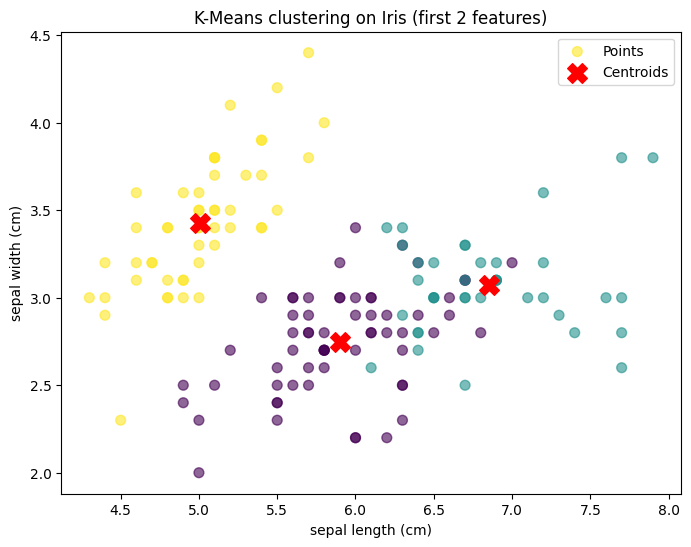

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(X_iris[:,0], X_iris[:,1], c=best_zs, cmap='viridis', s=50, alpha=0.6, label='Points')
plt.scatter(best_us[:,0], best_us[:,1], c='red', s=200, marker='X', label='Centroids')
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.title("K-Means clustering on Iris (first 2 features)")
plt.legend()
plt.show()

In [5]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X_iris)

print("Kmeans loss:", kmeans.inertia_)

Kmeans loss: 78.85566582597727


Normalised Mutual Info Score: 0.7419116631817836


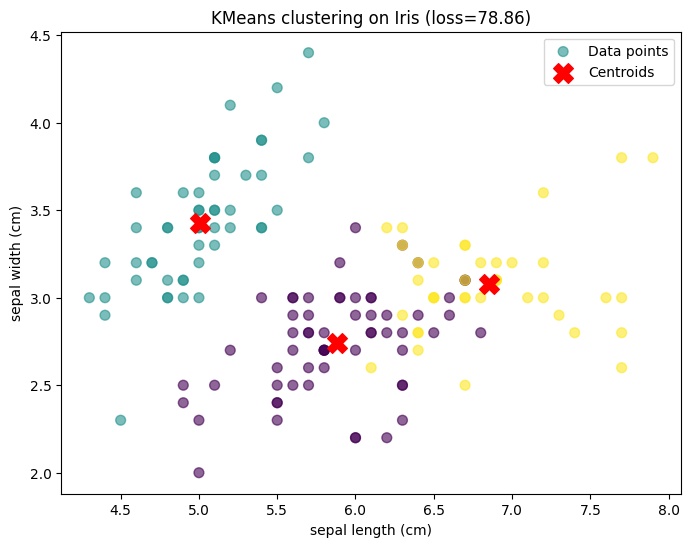

In [10]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans

# Load data
iris = load_iris()
X = iris.data

# Fit KMeans
kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_

# Plot first two features
print(f"Normalised Mutual Info Score: {normalized_mutual_info_score(labels, y_iris)}")
plt.figure(figsize=(8,6))
plt.scatter(X[:,0], X[:,1], c=labels, cmap='viridis', s=50, alpha=0.6, label='Data points')
plt.scatter(centroids[:,0], centroids[:,1], c='red', s=200, marker='X', label='Centroids')
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.title(f"KMeans clustering on Iris (loss={kmeans.inertia_:.2f})")
plt.legend()
plt.show()

With more dimensions the euclidean distance from points to centroids converge to one or very similar. In those cases the distance measure changes, below I give an example of spherical k-means. It is commonly used in higher dimensional problems like text processing where distance is almost flat but angle (cosine similarity) can still separate points.

Note: Text processing requires too much RAM to run within this notebook, so have continued with the iris example for comparison.


**Assignment step**: Spherical K-means assigns a data point to the closest centroid based on cosine distance rather than Euclidean distance; specifically, for $i=1,\ldots, n$

$$z^{(i)} \leftarrow \arg\min_{k} \left (1- \frac{\boldsymbol{\mu}_k^\top \mathbf{x}^{(i)} }{\|\boldsymbol{\mu}_k\| \cdot \|\mathbf{x}^{(i)}\|}\right ),$$ where $\boldsymbol{\mu}_k^\top \mathbf{x}^{(i)} = \sum_{j=1}^d \boldsymbol{\mu}_{kj} \cdot \mathbf{x}^{(i)}_{j}$ denotes the inner product and $\|\mathbf{x}\|$ is $L_2$ norm of a vector $\mathbf{x}$: $\|\mathbf{x}\| = \sqrt{\mathbf{x}^\top \mathbf{x}}$.

**Update step**: Spherical K-means updates the centroids such that they are unit one vectors; for $k=1,\ldots, K$

$$\boldsymbol{\mu}_k \leftarrow \frac{\sum_{i=1}^n I(z^{(i)} =k) \cdot  \mathbf{x}^{(i)}}{\|\sum_{i=1}^n I(z^{(i)} =k) \cdot \mathbf{x}^{(i)}\|}.$$ Note that after the normalisation step, the centroids $\boldsymbol{\mu}_k$ are norm-one vectors: i.e. $\|\boldsymbol{\mu}_k\| = 1$ for $k=1,\ldots, K$.

**Repeat** the above two steps until the total cosine distance loss converges, where the loss is defined as
$$\texttt{loss} = \sum_{i=1}^n \left (1- \frac{\boldsymbol{\mu}_{z^{(i)}}^\top \mathbf{x}^{(i)} }{\|\boldsymbol{\mu}_{z^{(i)}}\| \cdot \|\mathbf{x}^{(i)}\|}\right ).$$

In [7]:
import numpy as np
import numpy.linalg as linalg

def sphericalKMeans_assignment_step(data, μs):
    _, k = μs.shape
    n, d = data.shape
    zs = np.zeros(n)
    # Inner product
    dots = np.dot(data, μs.T)
    # L2 norm
    μs_norms = linalg.norm(μs, axis=1)
    data_norms = linalg.norm(data, axis=1)
    # Broadcast
    denominator = data_norms[:, np.newaxis] * μs_norms
    cosine_dists = 1-(dots/denominator)
    # Indicie of min value i.e. the closest centroid
    zs = np.argmin(cosine_dists, axis=1)
    # Distance to that centroid
    min_dis = np.min(cosine_dists, axis=1)
    return min_dis, zs, cosine_dists

def sphericalKMeans_update_step(data, zs, K):
    n, d = data.shape
    μs = np.zeros((K,d))
    for k in range(K):
        # filter data for assignments to K
        x_assignments = data[zs==k]
        # Sum filtered data
        μ_sum = np.sum(x_assignments, axis=0)
        # Magnitude
        μs[k] = μ_sum/linalg.norm(μ_sum)
    return μs

def sphericalKmeans(data, K=3, tol= 1e-4, maxIters= 100):
    n, d = data.shape
    losses = []
    centroids = []
    # initialisation: randomly assign K observations as centroids
    μs= data[np.random.choice(n, size=K, replace=False), :]
    zs = np.random.randint(0, K, size=n)
    # loop until converge
    for i in range(maxIters):
        # assignment step
        min_dis, zs, cosine = sphericalKMeans_assignment_step(data, μs)
        # update step
        μs = sphericalKMeans_update_step(data, zs, K)
        # compute loss
        loss = np.sum(min_dis)
        losses.append(loss)
        # convergence check
        if i > 0 and abs(losses[-2] - loss) < tol:
            break
    return losses, zs, μs

In [11]:
from sklearn.datasets import load_iris
from sklearn.metrics import normalized_mutual_info_score

iris=load_iris()
X_iris = iris.data
y_iris = iris.target

spherical_losses_all = []
spherical_μs_all = []
spherical_zs_all = []

for i in range(10):
    spherical_losses, spherical_zs, spherical_μs = sphericalKmeans(X_iris, K=3)
    spherical_losses_all.append(spherical_losses)
    spherical_μs_all.append(spherical_μs)
    spherical_zs_all.append(spherical_zs)

spherical_final_losses = [losses[-1] for losses in spherical_losses_all]
spherical_best_index = np.argmin(spherical_final_losses)
spherical_best_losses = spherical_losses_all[spherical_best_index]
best_loss_final = spherical_best_losses[-1]
spherical_best_us = spherical_μs_all[spherical_best_index]
spherical_best_zs = spherical_zs_all[spherical_best_index]

print(f"Normalised Mutual Info Score: {normalized_mutual_info_score(spherical_best_zs, y_iris)}")

Normalised Mutual Info Score: 0.8996935451597475


Spherical KMeans performs better; Higher mutual info score means more predicted labels match actual labels.